In [1]:
import csv
import json
import re
from konlpy.tag import Okt
from collections import defaultdict, Counter
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import matplotlib.font_manager as fm
from wordcloud import WordCloud
import pandas as pd
import seaborn as sns

In [2]:
# csv 파일 json 파일로 변환
csv_file_path = '멜론차트.csv'

json_data = []

with open(csv_file_path, mode='r', encoding='utf-8') as csv_file:
    csv_reader = csv.DictReader(csv_file) 
    for row in csv_reader:
        json_data.append(row)

with open('멜론차트.json', mode='w', encoding='utf-8') as json_file:
    json.dump(json_data, json_file, indent=4, ensure_ascii=False)

In [3]:
#데이터 가져오기
data_json = json.loads(open('멜론차트.json','r', encoding = 'utf8').read())
data = pd.read_csv('멜론차트.csv', encoding='utf8')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   연도      800 non-null    int64 
 1   순위      800 non-null    int64 
 2   곡명      800 non-null    object
 3   가수명     800 non-null    object
 4   장르      800 non-null    object
dtypes: int64(2), object(3)
memory usage: 31.4+ KB


In [4]:
font_path= "c:/Windows/fonts/malgun.ttf"
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [5]:
# 가수 빈도 카운트
singer = [entry['가수명'] for entry in data_json]
singer_counts = Counter(singer)

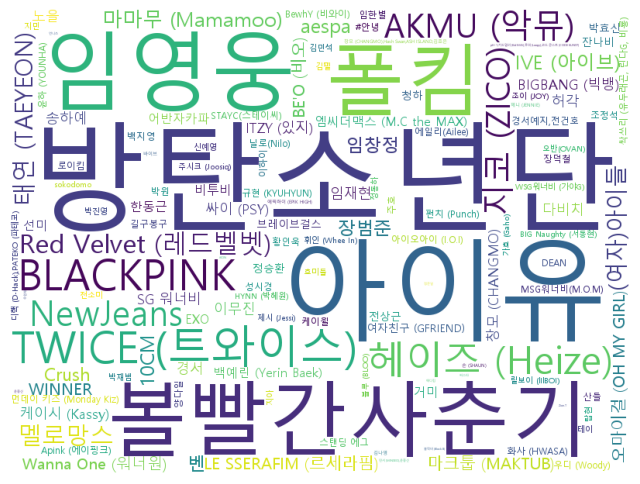

In [6]:
# 워드클라우드 출력
wc= WordCloud(font_path, 
              background_color= 'white', 
              width = 800, 
              height = 600,
              colormap='viridis')
cloud = wc.generate_from_frequencies(singer_counts)
plt.figure(figsize= (8, 8))
plt.imshow(cloud)
plt.axis('off')
plt.show()

In [7]:
# 상위 10명의 가수
top_10_singers = singer_counts.most_common(10)
top_10_singers_df = pd.DataFrame(top_10_singers, columns=['가수명', '빈도'])

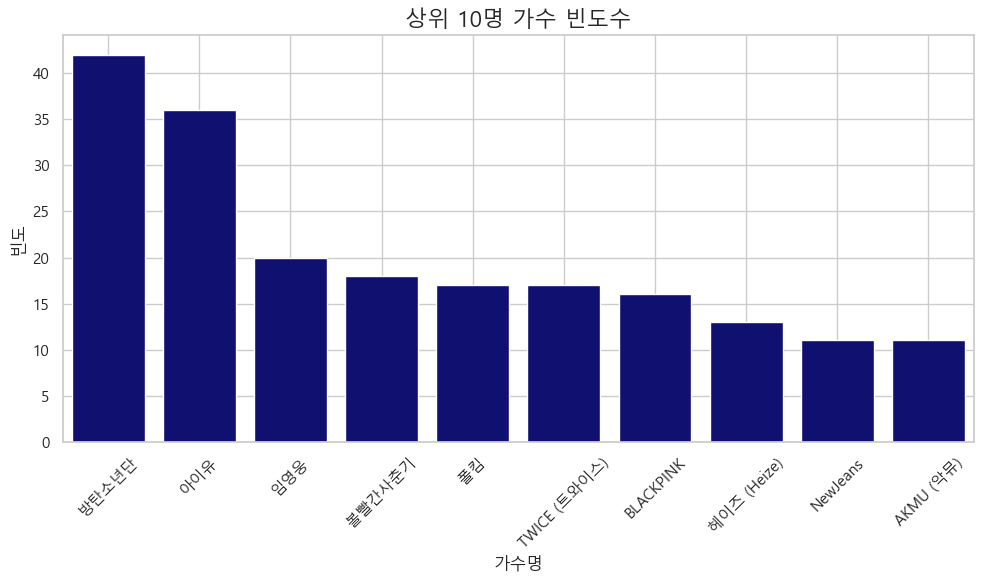

In [8]:
# 상위 10명의 가수 출력
sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_10_singers_df, 
    x='가수명', 
    y='빈도', 
    color='navy'
)
plt.title('상위 10명 가수 빈도수', fontsize=16)
plt.xlabel('가수명', fontsize=12)
plt.ylabel('빈도', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

In [9]:
# 장르별 곡 수
data = pd.read_csv('멜론차트.csv', encoding='utf8')
all_genres = data['장르'].str.split(',').explode().str.strip() #장르가 여러개 있는 곡의 경우 쉼표로 분리 후 병합
genre_counts = Counter(all_genres)
genre_counts_df = pd.DataFrame(genre_counts.items(), columns=['장르', '빈도']).sort_values(by='빈도', ascending=False)

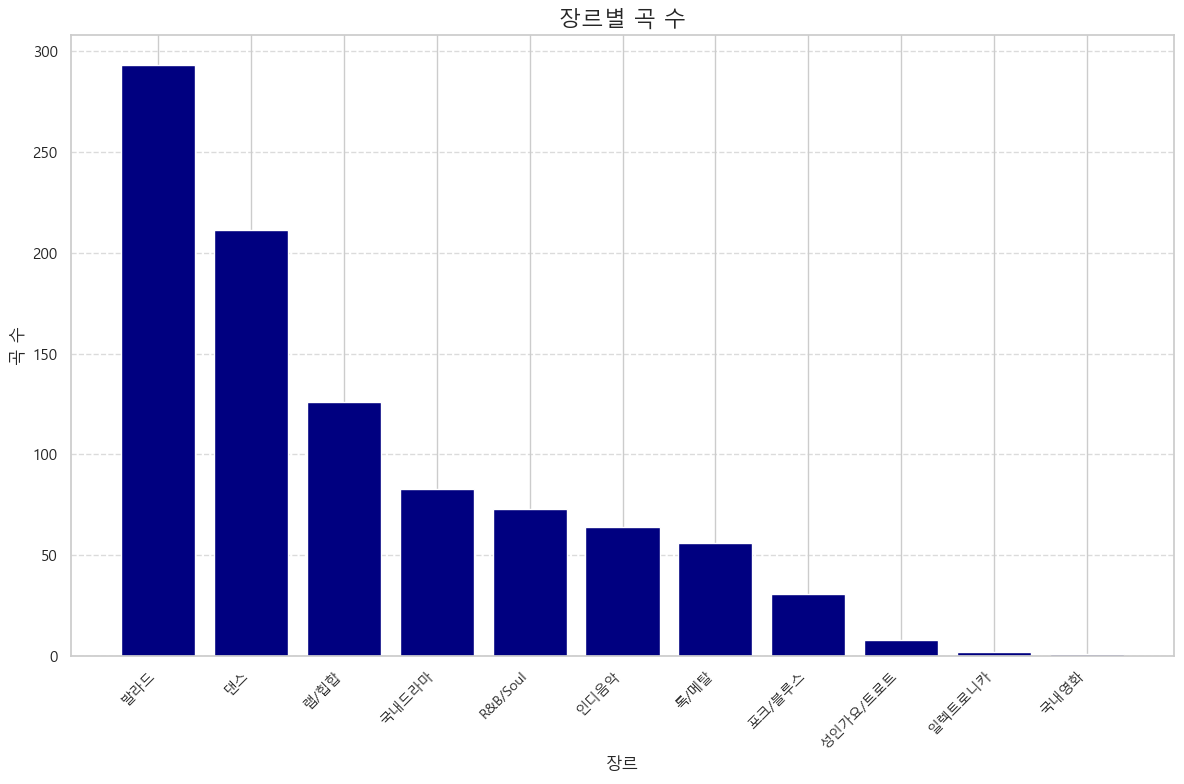

In [10]:
plt.figure(figsize=(12, 8))
plt.bar(genre_counts_df['장르'], genre_counts_df['빈도'], color='navy')
plt.title('장르별 곡 수', fontsize=16)
plt.xlabel('장르', fontsize=12)
plt.ylabel('곡 수', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [11]:
# 연도별로 장르별 곡 수 카운트
year_genre_count = {}
for year, group in data.groupby('연도'): 
    genres = group['장르'].str.split(',').explode().str.strip()
    year_genre_count[year] = Counter(genres)

# 연도별 상위 3개 장르 추출
top_genres_per_year = {}
for year, genre_counts in year_genre_count.items():
    top_genres_per_year[year] = genre_counts.most_common(3)

# 연도별로 정리
years = sorted(top_genres_per_year.keys())
top_genres = {}
for year in years:
    for genre, count in top_genres_per_year[year]:
        if genre not in top_genres:
            top_genres[genre] = []
        top_genres[genre].append((year, count))

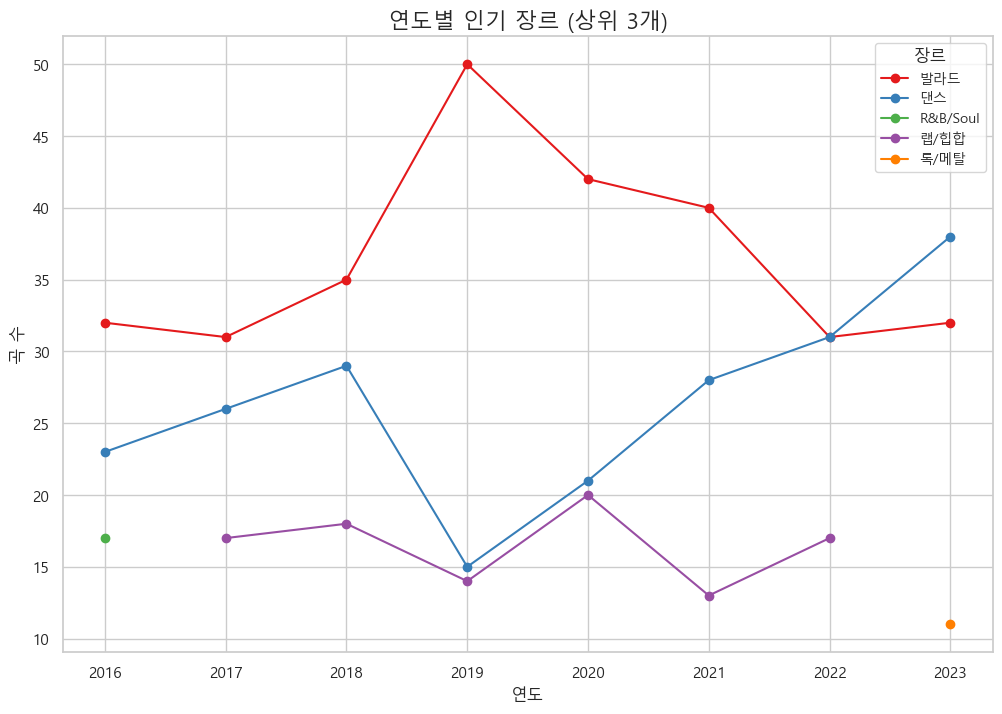

In [12]:
sns.set_palette("Set1")
plt.figure(figsize=(12, 8))
for genre, data in top_genres.items():
    data = sorted(data, key=lambda x: x[0])  # 연도순 정렬
    x = [int(year) for year, _ in data]
    y = [count for _, count in data]
    plt.plot(x, y, marker='o', label=genre)

plt.title('연도별 인기 장르 (상위 3개)', fontsize=16)
plt.xlabel('연도', fontsize=12)
plt.ylabel('곡 수', fontsize=12)
plt.legend(title='장르', fontsize=10)
plt.grid(True)
plt.show()

In [13]:
data = pd.read_csv('멜론차트.csv', encoding='utf8')

# 장르가 여러개 있는 곡의 경우 쉼표로 분리 후 병합
data_expanded = data.assign(장르=data['장르'].str.split(',')).explode('장르').reset_index(drop=True)
data_expanded['장르'] = data_expanded['장르'].str.strip() 

# 10위 단위로 구간을 나눔
data_expanded['순위'] = pd.to_numeric(data_expanded['순위'], errors='coerce')
data_expanded['순위_구간'] = pd.cut(data_expanded['순위'], bins=range(1, 111, 10), right=False, labels=[f'{i}-{i+9}' for i in range(1, 101, 10)])

# 장르와 순위 구간별 빈도 계산
genre_rank_correlation = data_expanded.groupby(['장르', '순위_구간']).size().reset_index(name='빈도')

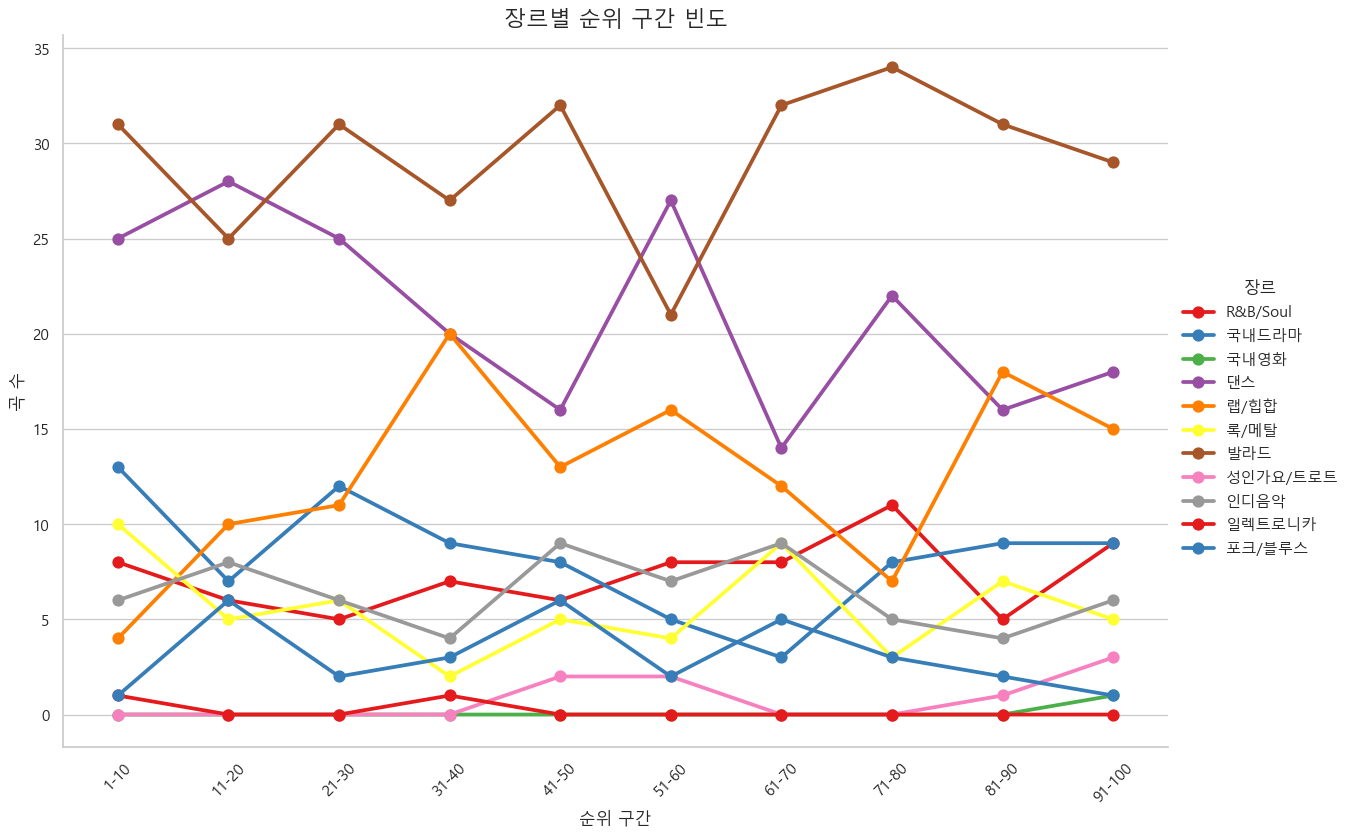

In [14]:
sns.set(style="whitegrid")
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

plot = sns.catplot(
    data=genre_rank_correlation, 
    x="순위_구간", 
    y="빈도", 
    hue="장르", 
    kind="point",  
    height=8, 
    aspect=1.5,
    palette="Set1",  
    markers="o",  
    linestyles='-'  
)
plot._legend.set_title("장르") 
plt.title("장르별 순위 구간 빈도", fontsize=16)
plt.xlabel("순위 구간", fontsize=12)
plt.ylabel("곡 수", fontsize=12)
plt.xticks(rotation=45)
plt.show()

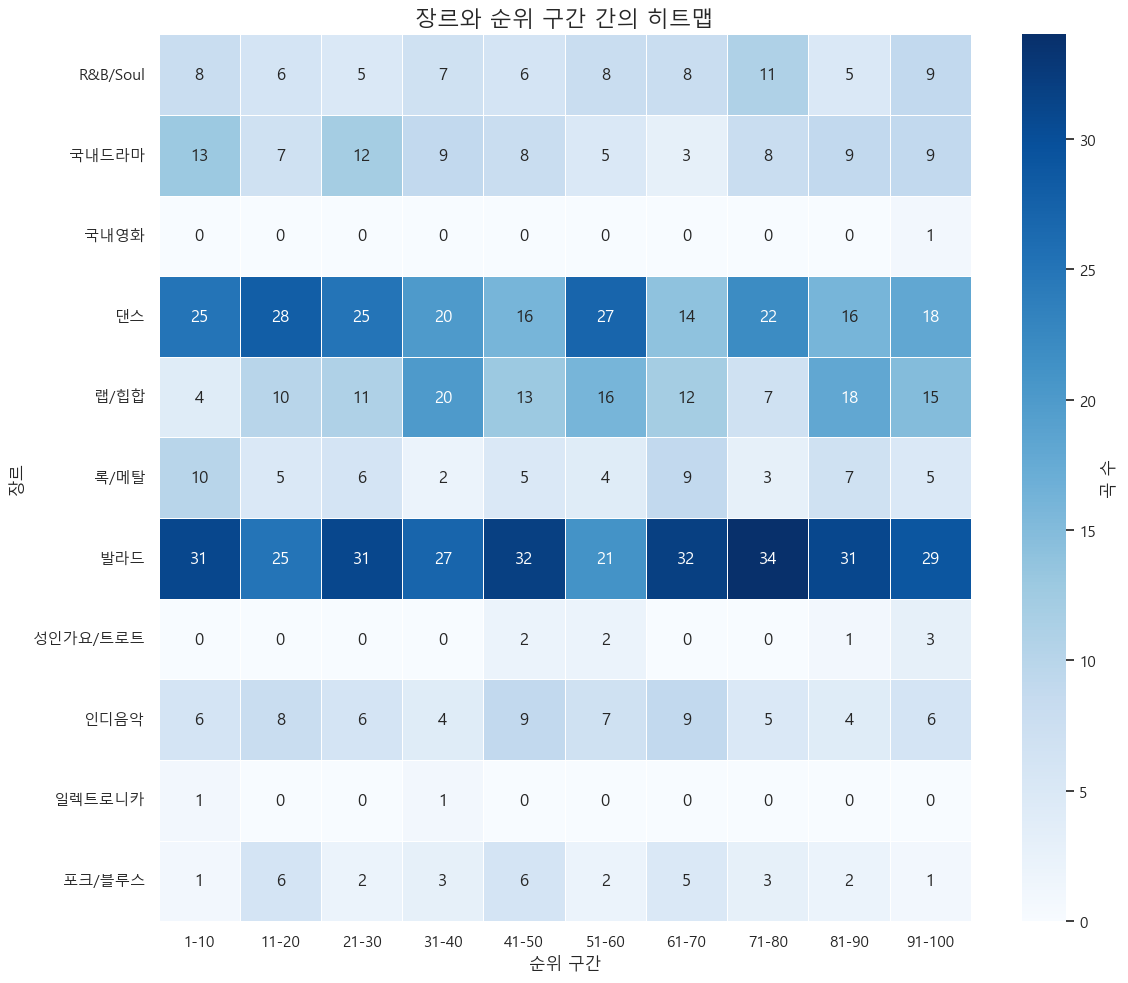

In [15]:
pivot_table = genre_rank_correlation.pivot(index="장르", columns="순위_구간", values="빈도").fillna(0)

plt.figure(figsize=(12, 10))
sns.heatmap(
    pivot_table, 
    annot=True, 
    fmt=".0f", 
    cmap="Blues", 
    linewidths=.5,  
    cbar_kws={"label": "곡 수"} 
)
plt.title("장르와 순위 구간 간의 히트맵", fontsize=16)
plt.xlabel("순위 구간", fontsize=12)
plt.ylabel("장르", fontsize=12)
plt.tight_layout()
plt.show()